In [47]:
from load_data import * 
from helpers import mtanh, calculate_pressure, normal_distribution, TransParams, solve_pde, T_model, n_model, get_chi_inter, get_d_inter, BCS, solve_time_evolution

import matplotlib.pyplot as plt 
import scienceplots 
import os 
import sys 
plt.style.use(['science', 'grid'])

In [72]:
BASE_PULSE_DIR = "/home/akadam/EUROfusion/2024/data"
shot_num = 83628
PULSE_STRUCT_DIR = os.path.join(BASE_PULSE_DIR, f"jet_{shot_num}")
JET_PDB_DIR = "/home/akadam/EUROfusion/2024/data"

psi_eval = np.linspace(0.8, 1.0, 100)

pulse = load_single_pulse_struct(PULSE_STRUCT_DIR)
relevant_profiles = pulse.return_profiles_in_time_windows()

te_fit_params, ne_fit_params, pe_fit_params  = get_fit_params_from_pdbshot(JET_PDB_DIR, pulse.shot_num)

steady_state_te = mtanh(psi_eval, te_fit_params.h1, te_fit_params.h0, te_fit_params.s, te_fit_params.w, te_fit_params.p)
steady_state_ne = mtanh(psi_eval, ne_fit_params.h1, ne_fit_params.h0, ne_fit_params.s, ne_fit_params.w, ne_fit_params.p)
steady_state_pe = mtanh(psi_eval, pe_fit_params.h1, pe_fit_params.h0, pe_fit_params.s, pe_fit_params.w, pe_fit_params.p)

steady_state_ne_mod = mtanh(psi_eval, ne_fit_params.h1, ne_fit_params.h0, ne_fit_params.s, te_fit_params.w, te_fit_params.p)

evolution_te = np.load(f'./temperature_{shot_num}.npy')
evolution_ne = np.load(f'./density_{shot_num}.npy')
evolution_pe = np.load(f'./pressure_{shot_num}.npy')
evolution_time = np.load(f'./time_{shot_num}.npy')

""" Plotting of crash """
if shot_num == 83624:
    offset = 0.04
elif shot_num == 83628:
    offset = 0.052
elif shot_num == 83625:
    offset = 0.035
else: 
    offset = 0.0

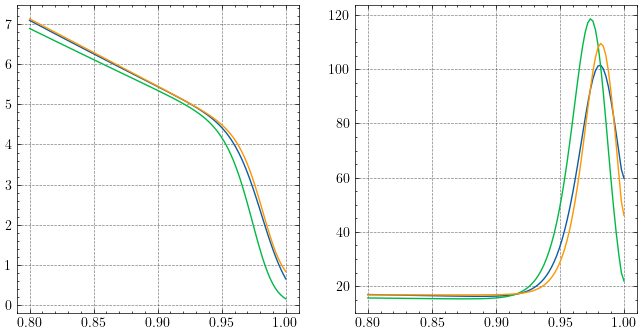

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

pres_avg = calculate_pressure(steady_state_te, steady_state_ne)
pres_mod = calculate_pressure(steady_state_te, steady_state_ne_mod)


axs[0].plot(psi_eval, pres_avg, label='Steady state')
axs[0].plot(psi_eval, pres_mod, label='Steady state mod')
axs[0].plot(psi_eval, steady_state_pe) 
axs[1].plot(psi_eval, abs(np.gradient(pres_avg, psi_eval)))
axs[1].plot(psi_eval, abs(np.gradient(pres_mod, psi_eval)))
axs[1].plot(psi_eval, abs(np.gradient(steady_state_pe, psi_eval)))

(10000, 100) (10000, 100)


(0.49504950495049505, 0.54005400540054)

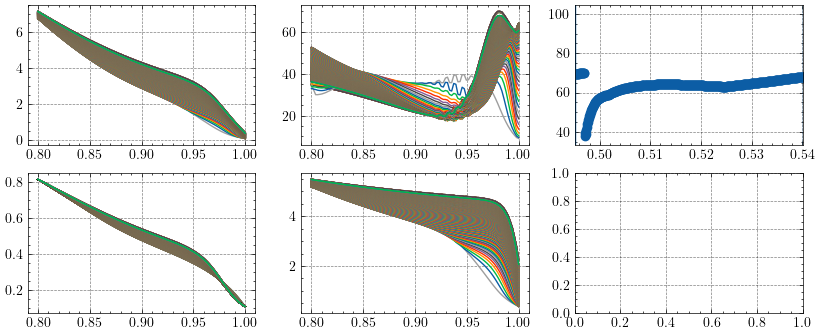

In [57]:
pressure_grad = np.gradient(evolution_pe, psi_eval, axis=1) # / evolution_pe
print(evolution_pe.shape, pressure_grad.shape)
fig, axs = plt.subplots(2, 3, figsize=(10, 4))
t_beg, t_end = 4950, 5400
axs = axs.ravel()
for t_idx in range(t_beg, t_end): 
    axs[0].plot(psi_eval, evolution_pe[t_idx])
    axs[1].plot(psi_eval, abs(pressure_grad[t_idx]))
    axs[3].plot(psi_eval, evolution_te[t_idx])
    axs[4].plot(psi_eval, evolution_ne[t_idx])
    

axs[2].scatter(evolution_time, abs(np.max(abs(pressure_grad), axis=1)))
axs[2].axvline(evolution_time[t_beg])
axs[2].axvline(evolution_time[t_end])

axs[2].set_xlim(evolution_time[t_beg], evolution_time[t_end])

(0.0, 10.0)

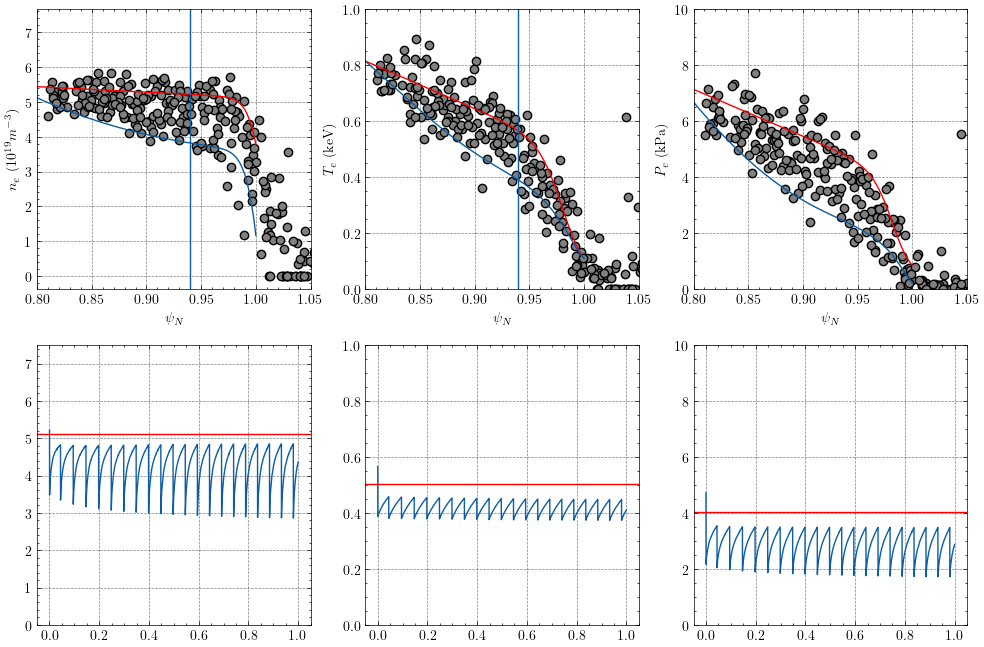

In [50]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.ravel()

axs[0].scatter(relevant_profiles.hrts_psi + offset, relevant_profiles.ne*1E-19, color='grey', edgecolors='black')
axs[0].plot(psi_eval, steady_state_ne, color='red')


axs[1].scatter(relevant_profiles.hrts_psi + offset, relevant_profiles.te*1E-3, color='grey', edgecolors='black')
axs[1].plot(psi_eval, steady_state_te, color='red')

axs[2].scatter(relevant_profiles.hrts_psi + offset, calculate_pressure(relevant_profiles.te*1E-3, relevant_profiles.ne*1E-19), color='grey', edgecolors='black', label=f'Data in {pulse.t1:.4} - {pulse.t2:.4}')
axs[2].plot(psi_eval, steady_state_pe, color='red', label='JET PDB Fit')

axs[0].set_xlim(0.0, 7.5)
axs[1].set_ylim(0.0, 1)
axs[2].set_ylim(0, 10)
for ax in axs[:3]: 
    ax.set_xlim(0.8, 1.05)
    ax.set_xlabel(r'$\psi_N$')
axs[0].set_ylabel(r'$n_e$ ($10^{19} m^{-3}$)')
axs[1].set_ylabel(r'$T_e$ (keV)')
axs[2].set_ylabel(r'$P_e$ (kPa)')

PED_IDX  = np.argmin(abs(psi_eval - (te_fit_params.p - te_fit_params.w)))
t_idx = 1000
axs[0].plot(psi_eval, evolution_ne[t_idx])
axs[1].plot(psi_eval, evolution_te[t_idx])
axs[2].plot(psi_eval, evolution_pe[t_idx])
axs[3].plot(evolution_time, evolution_ne[:, PED_IDX])
axs[4].plot(evolution_time, evolution_te[:, PED_IDX])
axs[5].plot(evolution_time, evolution_pe[:, PED_IDX])
axs[3].axhline(ne_fit_params.h1, color='red')
axs[4].axhline(te_fit_params.h1, color='red')
axs[5].axhline(pe_fit_params.h1, color='red')
for ax in axs[:2]: 
    ax.axvline(psi_eval[PED_IDX])

axs[3].set_ylim(0.0, 7.5)
axs[4].set_ylim(0.0, 1)
axs[5].set_ylim(0, 10)

